# Causal Inference of the GDP Growth

## Data process

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import the data

We choose to use the same dataset to do the causal inference.

In [2]:
df2 = pd.read_csv('data/Amelia.Imp3.csv')

### Feature Engineering

In [3]:
# drop the unrelated features
unrelated_feature = pd.Index(['Unnamed: 0', 'country', 'year', 'atwards'])

# GDP growth is the treatment feature
gdp_related_feature = pd.Index(['gdpgrowth'])

# output
y_feature = pd.Index(['warstds'])

# the rest features are the covariates
X_feature = df2.columns.drop(unrelated_feature)
X_feature = X_feature.drop(gdp_related_feature)
X_feature = X_feature.drop(y_feature)

## Treatment and control group

Because the GDP related features are not 0-1 variables and can't be divided into two groups directly. However, the casual inference of continuous treatment variable is much more complex than that of binary treatment variable. So we choose to divide the data into two groups base on the `gdp_growth`. First, let's draw the density plot of the `gdp_growth`:

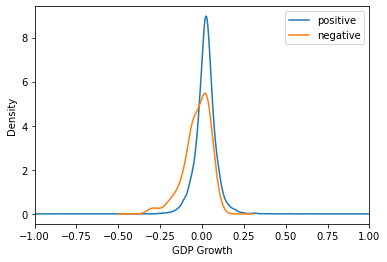

In [4]:
# draw the density of positive samples
df2[df2['warstds'] == 0]['gdpgrowth'].plot(kind = 'density', label = 'positive')

# draw the density of negative samples
df2[df2['warstds'] == 1]['gdpgrowth'].plot(kind = 'density', label = 'negative')

# add the legend
plt.legend()

# adjust x 
plt.xlim((-1, 1))
plt.xlabel("GDP Growth")

plt.show()

It seems that the distribution of positive and negative samples are similar. 

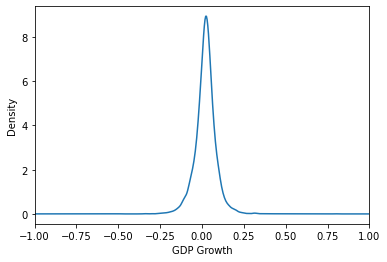

In [5]:
# draw the density of all samples
df2['gdpgrowth'].plot(kind = 'density')

plt.xlim((-1, 1))
plt.xlabel("GDP Growth")

plt.show()

If we choose to use a bound to do the classification, the bound must be near to 0. That means there will be many samples near the bound which belong to different group. 

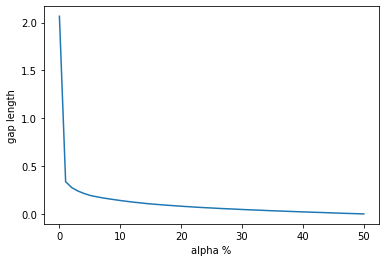

In [6]:
gdp_growth_array = np.array(df2['gdpgrowth'])

# we use the percentile of the gdp growth to divide the samples into three groups
alpha_list = np.linspace(0, 50, 50)

# the gap of the treatment group and control group
delta_list = []

for a in alpha_list:
    # the a percentile
    d1 = np.percentile(gdp_growth_array, a)
    
    # the 100-a percentile
    d2 = np.percentile(gdp_growth_array, 100-a)
    
    # the gap of two groups
    delta_list.append(d2-d1)

plt.plot(alpha_list, delta_list)
plt.xlabel("alpha %")
plt.ylabel("gap length")
plt.show()

We can choose a proper alpha to make sure that the gap is big enough, as well as the sample size is also big enough.

In [7]:
def get_treatment(alpha):
    # alpha percentile
    d_low = np.percentile(gdp_growth_array, alpha)
    
    # 100 - alpha percentile
    d_high = np.percentile(gdp_growth_array, 100 - alpha)
    
    # drop the samples in "middle" region
    df2_bin = df2.drop(index = df2[(df2['gdpgrowth'] >= d_low) & (df2['gdpgrowth'] <= d_high)].index)
    
    # the treatment group has the higher gdpgrowth
    df2_bin['treat'] = (df2_bin['gdpgrowth'].copy() > d_low).astype('int')
    
    return df2_bin

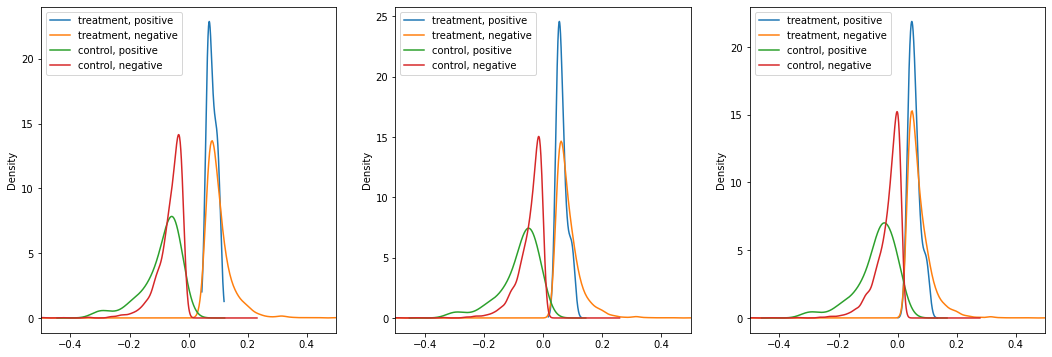

In [8]:
fig, ax = plt.subplots(figsize=(18, 6),ncols = 3)

# try different alpha
alpha_list = [20, 30, 40]

for i in range(3):
    # get the treatment and control group
    df_bin = get_treatment(alpha_list[i])
    
    # draw the density curve
    df_bin[(df_bin['treat'] == 1) & (df_bin['warstds'] == 1)]['gdpgrowth'].plot(kind = 'density', label = 'treatment, positive', ax = ax[i])
    df_bin[(df_bin['treat'] == 1) & (df_bin['warstds'] == 0)]['gdpgrowth'].plot(kind = 'density', label = 'treatment, negative', ax = ax[i])
    df_bin[(df_bin['treat'] == 0) & (df_bin['warstds'] == 1)]['gdpgrowth'].plot(kind = 'density', label = 'control, positive', ax = ax[i])
    df_bin[(df_bin['treat'] == 0) & (df_bin['warstds'] == 0)]['gdpgrowth'].plot(kind = 'density', label = 'control, negative', ax = ax[i])
    
    ax[i].set_xlim((-0.5, 0.5))
    ax[i].legend(loc='upper left')
plt.show()

It shows that 30 percentile is a good choice because:
* we can use 60% of the samples. That's not a small sample size.
* There exists a gap between the two groups obviously.

In [9]:
df_bin = get_treatment(30)

## Explore the other features

Now we want to check if the covariates are really imbalance in the two groups. We can use a t-test to verify if the mean of the same covariate in different groups are the same or not.  

In [10]:
from scipy.stats import ttest_ind

# count the imbalanced covariates
sig_cnt = 0

# the t-statistics of each covariate
t_stat = {}

for f in X_feature:
    # treatment group
    trt_f = df_bin[df_bin['treat'] == 1][f]
    
    # control group
    ctr_f = df_bin[df_bin['treat'] == 0][f]
    
    # t-test
    t, p = ttest_ind(trt_f, ctr_f)
    
    if p < 0.05:
        sig = "*"
        sig_cnt = sig_cnt + 1
    else:
        sig = ""
        
    # update the t-statistics
    t_stat[f] = np.abs(t)
    
print("imbalance feature:", sig_cnt)

imbalance feature: 32


Let's plot the t-statistics of these tests:

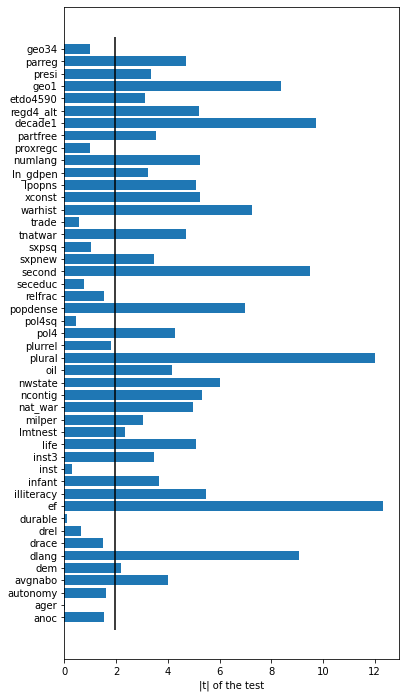

In [11]:
fig, ax = plt.subplots(figsize=(6, 12))

# use bar plot to show the value of t-statistics
ax.barh(list(t_stat.keys()), t_stat.values())

# the bound of 95% confidence 
ax.vlines(x=1.96, ymin=-1, ymax=len(X_feature))

ax.set_xlabel("|t| of the test")
plt.show()

We can see most of the features are imbalanced. So we can't do the comparison of two groups directly.

## Propensity score

We use propensity score to balance the covariates.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [13]:
# get the predict probability of classifier cls
def get_propensity_score(cls):
    # fit the model
    cls.fit(df_bin[X_feature], df_bin['treat'].values.ravel())
    
    # return the probabilities
    return cls.predict_proba(df_bin[X_feature])[:, 1]

In [14]:
# plot the density curve of the propensity score
def density_propensity_score(score, ax):
    df_bin[(df_bin['treat'] == 1)&(df_bin['warstds'] == 1)][score].plot(kind = 'density', 
                                                                        linestyle = '-',
                                                                        color = 'blue',
                                                                        label = 'trt, pos',
                                                                        ax = ax)
    df_bin[(df_bin['treat'] == 1)&(df_bin['warstds'] == 0)][score].plot(kind = 'density', 
                                                                        linestyle = '--',
                                                                        color = 'blue',
                                                                        label = 'trt, neg',
                                                                        ax = ax)
    df_bin[(df_bin['treat'] == 0)&(df_bin['warstds'] == 1)][score].plot(kind = 'density', 
                                                                        linestyle = '-',
                                                                        color = 'red',
                                                                        label = 'ctr, pos',
                                                                        ax = ax)
    df_bin[(df_bin['treat'] == 0)&(df_bin['warstds'] == 0)][score].plot(kind = 'density', 
                                                                        linestyle = '--',
                                                                        color = 'red',
                                                                        label = 'ctr, neg',
                                                                        ax = ax)
    ax.legend()

We try to use three different model to get the propensity score:
* Logistic Regression
* Random Forest
* Support Vector Machine

In [15]:
# linear regression
cls_lr = LogisticRegression(max_iter = 10000)

# random forest
cls_rf = RandomForestClassifier(n_estimators=1000,
                                oob_score=True,
                                class_weight='balanced')

# SVM
cls_svm = svm.SVC(random_state = 0,
                  probability=True)

Get the propensity score:

In [16]:
df_bin['prop_score_lr'] = get_propensity_score(cls_lr)

In [17]:
df_bin['prop_score_rf'] = get_propensity_score(cls_rf)

In [18]:
df_bin['prop_score_svm'] = get_propensity_score(cls_svm)

Plot the result:

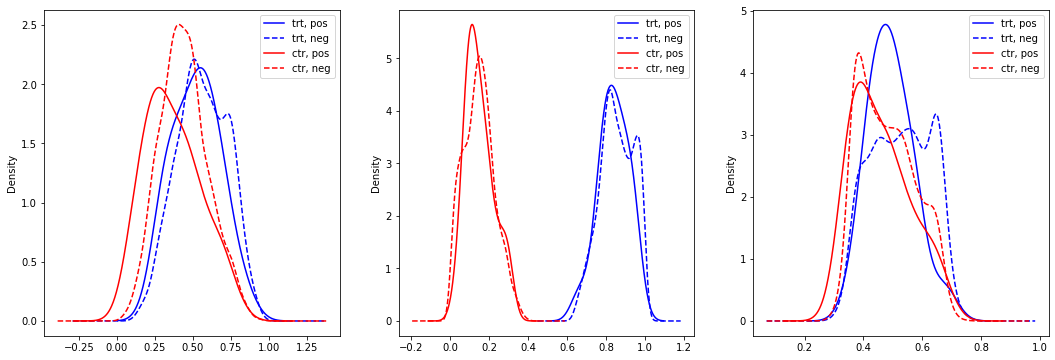

In [19]:
fig, ax = plt.subplots(ncols=3, figsize = (18, 6))
density_propensity_score('prop_score_lr', ax[0])
density_propensity_score('prop_score_rf', ax[1])
density_propensity_score('prop_score_svm', ax[2])

We can see that if we choose to use the propensity score given by Random Forest model, we can not find a pair of data sharing the same propensity score, which belong to different groups. So Random Forest is a bad choice. Both SVM and Logistic Regression can work well and we choose to use the Logistic Regression to generate the propensity score. 

In [20]:
df_bin['prop_score'] = df_bin['prop_score_lr'].copy()

## Matching

In this part we will try to match the samples which have similar propensity scores and belong to different groups.

In [21]:
# the index of the sample
df_bin['ind'] = range(df_bin.shape[0])  

# use dictionaries to save <index> : <propensity score>
trt_score = {}
ctr_score = {}
for ind, row in df_bin.iterrows():
    if row['treat'] == 1:
        trt_score[row['ind']] = row['prop_score']
    else:
        ctr_score[row['ind']] = row['prop_score']

In [22]:
# sort the dictionaries
trt_score_sorted = sorted(trt_score.items(), key = lambda kv:(kv[1], kv[0]))
ctr_score_sorted = sorted(ctr_score.items(), key = lambda kv:(kv[1], kv[0]))

In [23]:
# show the range of two groups
print("Treatment group:", trt_score_sorted[0][1], "-", trt_score_sorted[-1][1])
print("Control group:", ctr_score_sorted[0][1], "-", ctr_score_sorted[-1][1])

Treatment group: 0.12422556251215516 - 0.9538858579939603
Control group: 0.051923849968530535 - 0.9346422681217595


In [72]:
# we need to make sure the propensity score of two groups are in the same interval
# so we should drop some samples in control group, which have propensity score lower than 0.124
for i in range(len(trt_score_sorted)):
    if ctr_score_sorted[i][1] > trt_score_sorted[0][1]:
        print(i)
        break

24


We use greedy search to do the matching. The algorithm is:

1. Drop some samples to make sure the two groups have the same range of propensity score.

2. $t = min\_propensity\_score(Treatment)$, the sample is $s_t$

3. $c = min\_propensity\_score(Control)$, the sample is $s_c$

4. Compare $t$ and $c$:
   1. $t - c > \delta$: drop $s_c$
   2. $t - c < -\delta$: drop $s_t$
   3. otherwise: match $(s_c, s_t)$ and drop them
   
5. If there is no sample in Treatment Group or Control Group, return all the matches. Otherwise go back to step 2

In [24]:
# because our propensity score have been sorted
# so we can use the index to show the position of selection
# the initial position and bound can be passed to the function
def generate_pairs(t, c, init_t, init_c, bound):
    # list to save the pairs
    pairs = []
    
    # list to save the difference of propensity score
    diffs = []
    
    # init the index
    ind_t = init_t
    ind_c = init_c

    # when there are samples in both of the groups
    while ind_t < len(trt_score_sorted) and ind_c < len(ctr_score_sorted):
        
        # the ind_t points to the minimum of the treatment group
        # and the ind_c points to the minimum of the control group
        # we can get the difference of the two minimums
        diff = trt_score_sorted[ind_t][1] - ctr_score_sorted[ind_c][1]
        
        if diff < -bound:
            # if min(c) is much bigger than min(t)
            # drop the min(t)
            # then the min(t) will be bigger
            ind_t = ind_t + 1
        elif diff > bound:
            # if min(c) is much smaller than min(t)
            # drop the min(c)
            # then the min(c) will be bigger
            ind_c = ind_c + 1
        else:
            # if the difference between them are suitable
            # match min(c) and min(t)
            pairs.append((trt_score_sorted[ind_t][0], ctr_score_sorted[ind_c][0]))
            
            # save the difference
            diffs.append(diff)
            
            # and update both the min(t) and min(c)
            ind_t = ind_t + 1
            ind_c = ind_c + 1
    
    # return the matching plan and the difference of each pair
    return pairs, diffs

In [25]:
# we will try different bound
bound_list = [0.01, 0.0005, 0.0002, 0.0001]

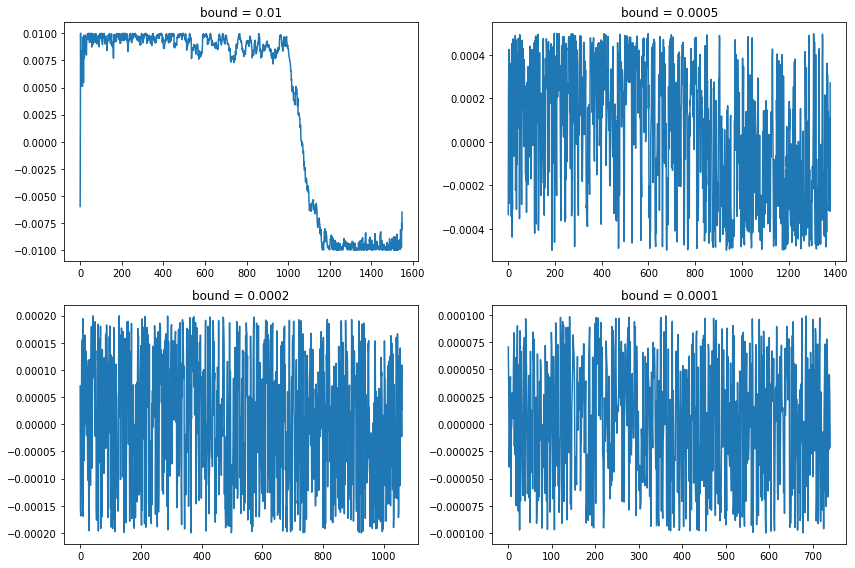

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

for ind in range(len(bound_list)):
    pairs, diffs = generate_pairs(trt_score_sorted, ctr_score_sorted, 0, 30, bound_list[ind])
    ax[ind // 2][ind % 2].plot(range(len(diffs)), diffs)
    ax[ind // 2][ind % 2].set_title("bound = " + str(bound_list[ind]))
    
fig.tight_layout()

We can see that:
* If we use a loose bound, there will be some kind of biases
* If we use a tight bound, we can't get enough size of sample

And finally we choose the plan of bound = 0.0002, in order to make sure the differences are unbiased. And the sample size is also not so small.

In [27]:
pairs, diffs = generate_pairs(trt_score_sorted, ctr_score_sorted, 0, 30, 0.0002)

## Check the other features

Now, let's check the balance of covariates again.

In [28]:
pairs_trt_ind = [p[0] for p in pairs]
pairs_ctr_ind = [p[1] for p in pairs]

In [29]:
sig_cnt = 0
t_stat = {}

for f in X_feature:
    trt_f = df_bin.iloc[pairs_trt_ind][f]
    ctr_f = df_bin.iloc[pairs_ctr_ind][f]
    t, p = ttest_ind(trt_f, ctr_f)
    if p < 0.05:
        sig = "*"
        sig_cnt = sig_cnt + 1
    else:
        sig = ""
    t_stat[f] = np.abs(t) 
    
print("imbalance feature:", sig_cnt)

imbalance feature: 0


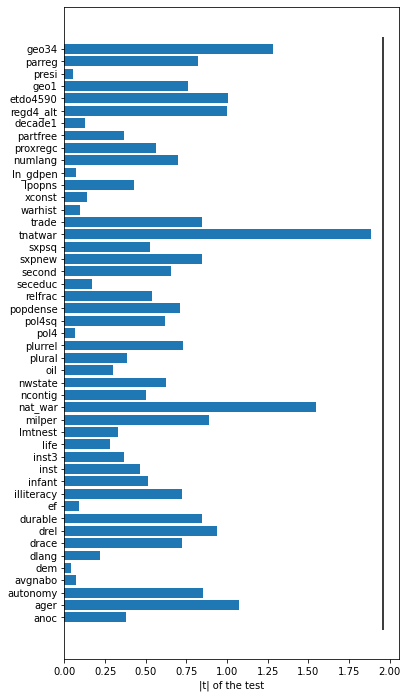

In [30]:
fig, ax = plt.subplots(figsize=(6, 12))
ax.barh(list(t_stat.keys()), t_stat.values())
ax.vlines(x=1.96, ymin=-1, ymax=len(X_feature))
ax.set_xlabel("|t| of the test")
plt.show()

We can see that all the features are balanced in the two groups. That means our matching work can really balance the covariates.

## Estimate the treatment effect

In [31]:
# save the difference of the result
y_diff = []

for p in pairs:
    y_trt = df_bin.iloc[p[1]]['warstds']
    y_ctr = df_bin.iloc[p[0]]['warstds']
    y_diff.append(y_trt - y_ctr)

# the mean effect
np.mean(y_diff)

0.006597549481621112

In [32]:
# the standard deviation
np.std(y_diff)

0.17080454172454274

This result shows that there is no evidence shows that the GDP growth can cause the civil war.

## Train a new model with the matching data

Finally, let's check if we get this result by using only part of the data. We will use the matching data to train the Random Forest model. And see if the GDP growth is still the most important feature.

In [33]:
# the matching data
df_pairs = df_bin.iloc[np.concatenate((pairs_trt_ind, pairs_ctr_ind))]

In [34]:
cls = RandomForestClassifier(random_state=0,
                             n_estimators = 1000, 
                             oob_score=True,
                             class_weight="balanced")

cls.fit(df_pairs[np.concatenate((X_feature, gdp_related_feature))], df_pairs[y_feature].values.ravel())

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       oob_score=True, random_state=0)

In [35]:
cls.feature_importances_

feat_importance = {}
for i in range(len(X_feature)):
    feat_importance[X_feature[i]] = cls.feature_importances_[i]

feat_importance['gdpgrowth'] = cls.feature_importances_[-1]
feat_top20 = sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)[:20]
feat_top20

[('gdpgrowth', 0.07343422257528646),
 ('life', 0.04864363751056198),
 ('ln_gdpen', 0.04677314925941324),
 ('infant', 0.044691458076051974),
 ('lmtnest', 0.04467932788472517),
 ('seceduc', 0.037648089142855425),
 ('sxpnew', 0.031764156104480745),
 ('trade', 0.029897659327115998),
 ('relfrac', 0.028252730080931838),
 ('illiteracy', 0.027844735421674007),
 ('sxpsq', 0.027297066984123475),
 ('lpopns', 0.026429909504937305),
 ('popdense', 0.02524646649562228),
 ('milper', 0.024783116031570237),
 ('partfree', 0.024457534804898956),
 ('avgnabo', 0.02422627552877949),
 ('ager', 0.023217322394311523),
 ('plurrel', 0.023146134549578642),
 ('pol4sq', 0.020891167843469706),
 ('numlang', 0.020513659702291933)]

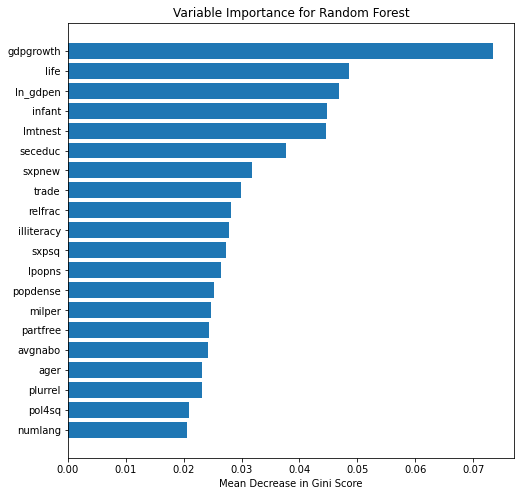

In [36]:
label = [item[0] for item in feat_top20]
score = [item[1] for item in feat_top20]


plt.figure(figsize=(8,8))
plt.barh(label[::-1], score[::-1])
plt.xlabel("Mean Decrease in Gini Score")
plt.title("Variable Importance for Random Forest")
plt.show()

We can see that even now, the GDP Growth is still the most important feature.

## Conclusion

Although some new machine learning models can achieve very good performance in prediction, it doesn't mean that these models can do everything. In this paper, we can get some useful information from the feature importance. However, the causality should not be included into it. 

The causality in statistics is a very serious topic, because it can lead to so much misunderstanding. But it doesn't means that the causality should not be in our consideration. Causal inference is still a very popular topic, and there are some very intesting findings in this topic.  

Actually, our result is not very exact. Because the dataset is so imbalanced. And over 98% of the samples are negative. That means the basic method of causal inference may have bad performance in verify causality of rare events. 